In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install keras-tuner --upgrade

In [ ]:
import numpy as np
import keras
import os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras import models
from keras import layers
from keras import optimizers
import cv2
import random
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from keras import metrics
import tensorflow as tf
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from keras import backend as K

# Data Loading and Pre-Processing

In [ ]:
bloodmnist_data = np.load('/content/drive/My Drive/BloodMNIST/bloodmnist.npz')

In [ ]:
# Training
X_train = bloodmnist_data['train_images']
y_train = bloodmnist_data['train_labels']
# Validation
X_val = bloodmnist_data['val_images']
y_val = bloodmnist_data['val_labels']
# Testing
X_test = bloodmnist_data['test_images']
y_test = bloodmnist_data['test_labels']

In [ ]:
# Check no records are missing
print('Training: no. images: {}, no. labels: {}'.format(len(X_train), len(y_train)))
print('Validation: no. images: {}, no. labels: {}'.format(len(X_val), len(y_val)))
print('Testing: no. images: {}, no. labels: {}'.format(len(X_test), len(y_test)))

Training: no. images: 11959, no. labels: 11959
Validation: no. images: 1712, no. labels: 1712
Testing: no. images: 3421, no. labels: 3421


Looks like all records are present as per https://medmnist.com/.<br>
Let's look at the distributions of samples across the classes.

In [ ]:
# Training
print('Training')
vals, counts = np.unique(y_train, return_counts=True)
train_counts = dict(zip(vals, counts))
print(train_counts)
train_percentages = dict(zip(vals, np.round(counts*100/len(y_train),2)))
print(train_percentages)
# Validation
print('Validation')
vals, counts = np.unique(y_val, return_counts=True)
val_counts = dict(zip(vals, counts))
print(val_counts)
val_percentages = dict(zip(vals, np.round(counts*100/len(y_val),2)))
print(val_percentages)
# Testing
print('Testing')
vals, counts = np.unique(y_test, return_counts=True)
test_counts = dict(zip(vals, counts))
print(test_counts)
test_percentages = dict(zip(vals, np.round(counts*100/len(y_test),2)))
print(test_percentages)
# Overall
print('Overall')
y_all = np.concatenate([y_train, y_val, y_test], axis=0)
vals, counts = np.unique(y_all, return_counts=True)
all_counts = dict(zip(vals, counts))
print(all_counts)
all_percentages = dict(zip(vals, np.round(counts*100/len(y_all),2)))
print(all_percentages)

Training
{0: 852, 1: 2181, 2: 1085, 3: 2026, 4: 849, 5: 993, 6: 2330, 7: 1643}
{0: 7.12, 1: 18.24, 2: 9.07, 3: 16.94, 4: 7.1, 5: 8.3, 6: 19.48, 7: 13.74}
Validation
{0: 122, 1: 312, 2: 155, 3: 290, 4: 122, 5: 143, 6: 333, 7: 235}
{0: 7.13, 1: 18.22, 2: 9.05, 3: 16.94, 4: 7.13, 5: 8.35, 6: 19.45, 7: 13.73}
Testing
{0: 244, 1: 624, 2: 311, 3: 579, 4: 243, 5: 284, 6: 666, 7: 470}
{0: 7.13, 1: 18.24, 2: 9.09, 3: 16.92, 4: 7.1, 5: 8.3, 6: 19.47, 7: 13.74}
Overall
{0: 1218, 1: 3117, 2: 1551, 3: 2895, 4: 1214, 5: 1420, 6: 3329, 7: 2348}
{0: 7.13, 1: 18.24, 2: 9.07, 3: 16.94, 4: 7.1, 5: 8.31, 6: 19.48, 7: 13.74}


We have an imbalanced dataset, with some classes having far more samples than others. The distribution of samples across classes is consistent across the training, validation and testing sets - they all reflect the overall distribution.<br>
Let's calculate class weights to tackle the data imbalance problem.

In [ ]:
# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train[:,0])
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 1.7545481220657277, 1: 0.6854080696928014, 2: 1.3777649769585254, 3: 0.7378455083909181, 4: 1.7607479387514724, 5: 1.5054128902316213, 6: 0.6415772532188841, 7: 0.9098447961046866}


Visualise a subset of the training data and ground truth

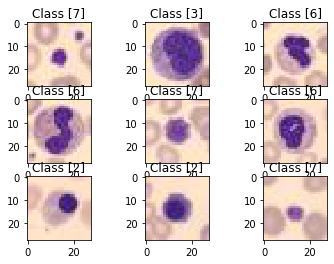

In [ ]:
# Visualise a subset of the training data and ground truth
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[i], interpolation='none')
    plt.title("Class {}".format(y_train[i]))

# Define training metrics

In [ ]:
# Define custom metrics
# https://datascience.stackexchange.com/questions/105101/which-keras-metric-for-multiclass-classification
# Include an epsilon term in the denominators to avoid potential divide-by-zero errors: https://www.tensorflow.org/api_docs/python/tf/keras/backend/epsilon

# Recall
def recall_m(y_true, y_pred):
  TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  recall = TP / (Positives+K.epsilon())
  return recall

# Precision
def precision_m(y_true, y_pred):
  TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = TP / (Pred_Positives+K.epsilon())
  return precision

# F1 Score
def f1_m(y_true, y_pred):    
  precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)  
  return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
# Common training parameters
IMG_SIZE = 224
num_classes = 8

In [ ]:
# Function to plot the training accuracy, validation accuracy, training loss, and validation loss
def plot_training_history(training_history):
  # Get training and validation accuracy histories
  training_accuracy = training_history.history["acc"]
  val_accuracy = training_history.history["acc"]
  # Get training and validation loss histories
  training_loss = training_history.history["loss"]
  val_loss = training_history.history["val_loss"]
  # Create count of the number of epochs
  epoch_count = range(1, len(training_loss) + 1)
  fig, ax = plt.subplots(1, 2, figsize=(15, 6))
  # Visualise accuracy history
  ax[0].plot(epoch_count, training_accuracy, "r--")
  ax[0].plot(epoch_count, val_accuracy, "b--")
  ax[0].legend(["Training Accuracy", "Validation Accuracy"])
  ax[0].set_xlabel("Epoch")
  ax[0].set_ylabel("Accuracy")
  # Visualise loss history
  ax[1].plot(epoch_count, training_loss, "r--")
  ax[1].plot(epoch_count, val_loss, "b--")
  ax[1].legend(["Training Loss", "Validation Loss"])
  ax[1].set_xlabel("Epoch")
  ax[1].set_ylabel("Loss")
  # Show the plot
  plt.show()

In [ ]:
# Function to display metrics and confusion matrix for a given model
def evaluate_model_performance(model):
  # Evaluate model
  scores = model.evaluate(X_test, y_test)

  # Print out all metrics
  print('')
  print('Metrics')
  for i in range(len(model.metrics_names)):
    print('{}: {}'.format(model.metrics_names[i], np.round(scores[i], 4)))
  print('')
  
  # Predict classes for test data
  y_pred = model.predict(X_test)
  y_pred_classes = np.argmax(y_pred, axis=1) # The class for each sample is the one with the highest probability

  # Plot confusion matrix
  fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
  ConfusionMatrixDisplay.from_predictions(y_test, y_pred_classes, normalize='pred', ax=axes, cmap=plt.cm.Blues)
  plt.show()

# Transfer Learning: VGG16 (Unbalanced dataset)

In [ ]:
# VGG16 Base
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

In [ ]:
# Freeze all layers except the last two
for i in range(len(conv_base.layers)-2):
    conv_base.layers[i].trainable=False

In [ ]:
model = models.Sequential()
model.add(layers.Resizing(IMG_SIZE, IMG_SIZE))
model.add(layers.Rescaling(1./255))
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu', kernel_regularizer='l2'))
model.add(layers.Dense(num_classes, activation='softmax'))

In [ ]:
# Compile the model for training
opt = Adam(learning_rate=1e-4)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['acc', precision_m, recall_m, f1_m])

In [ ]:
num_epochs = 25

# Callbacks
model_filepath = '/content/drive/My Drive/BloodMNIST/Models/vgg16_unbal'+'-saved-model-{epoch:02d}-acc-{val_acc:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(model_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=1e-6)

In [ ]:
hist = model.fit(X_train, y_train,
                 epochs=num_epochs,
                 validation_data=[X_val, y_val],
                 callbacks=[model_checkpoint, early_stopping, reduce_lr])

Epoch 1/25
374/374 [==============================] - ETA: 0s - loss: 2.0579 - acc: 0.7447 - precision_m: 28850270.0000 - recall_m: 1.5623 - f1_m: 1.8223
Epoch 1: val_acc improved from -inf to 0.83061, saving model to /content/drive/My Drive/BloodMNIST/Models/vgg16_unbal-saved-model-01-acc-0.83.hdf5
374/374 [==============================] - 65s 170ms/step - loss: 2.0579 - acc: 0.7447 - precision_m: 28850270.0000 - recall_m: 1.5623 - f1_m: 1.8223 - val_loss: 1.0728 - val_acc: 0.8306 - val_precision_m: 1.4633 - val_recall_m: 1.3660 - val_f1_m: 1.4105 - lr: 1.0000e-04
Epoch 2/25
374/374 [==============================] - ETA: 0s - loss: 0.9095 - acc: 0.8501 - precision_m: 1.4042 - recall_m: 1.3502 - f1_m: 1.3744
Epoch 2: val_acc improved from 0.83061 to 0.86040, saving model to /content/drive/My Drive/BloodMNIST/Models/vgg16_unbal-saved-model-02-acc-0.86.hdf5
374/374 [==============================] - 58s 156ms/step - loss: 0.9095 - acc: 0.8501 - precision_m: 1.4042 - recall_m: 1.3502 - 

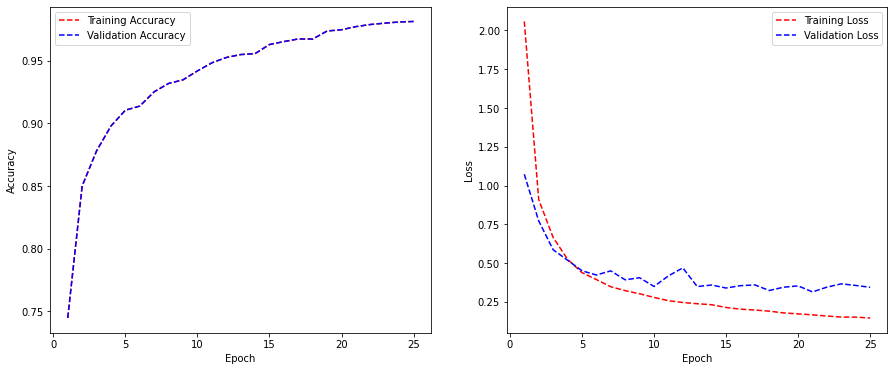

In [ ]:
plot_training_history(hist)

107/107 [==============================] - 14s 127ms/step - loss: 0.3488 - acc: 0.9082 - precision_m: 1.0681 - recall_m: 1.1311 - f1_m: 1.0981

Metrics
loss: 0.3488
acc: 0.9082
precision_m: 1.0681
recall_m: 1.1311
f1_m: 1.0981

107/107 [==============================] - 14s 133ms/step


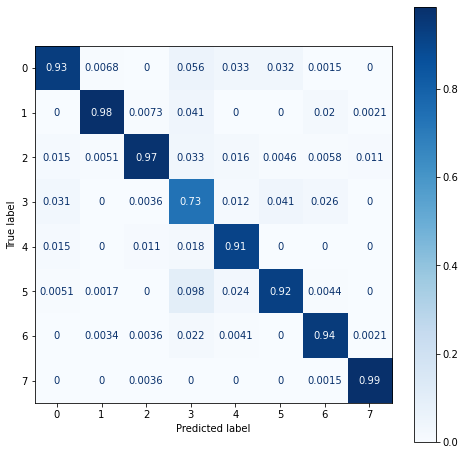

In [ ]:
evaluate_model_performance(model)

Overall accuracy is 90.82%. The confusion matrix shows that accuracy on class 3 is significantly lower than that for other classes.

# Transfer Learning: VGG16 (Class Weights)
Use the same hyperparameters etc as above, but include class weights to evaluate whether or not they improve the performance, particularly on minority classes.

In [ ]:
# VGG16 Base
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

In [ ]:
# Freeze all layers except the last two
for i in range(len(conv_base.layers)-2):
    conv_base.layers[i].trainable=False

In [ ]:
model2 = models.Sequential()
model2.add(layers.Resizing(IMG_SIZE, IMG_SIZE))
model2.add(layers.Rescaling(1./255))
model2.add(conv_base)
model2.add(layers.Flatten())
model2.add(layers.Dense(256, activation='relu', kernel_regularizer='l2'))
model2.add(layers.Dropout(0.2)) # Add Dropout to reduce overfitting
model2.add(layers.Dense(num_classes, activation='softmax'))

In [ ]:
# Compile the model for training
opt = Adam(learning_rate=1e-4)
model2.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['acc', precision_m, recall_m, f1_m])

In [ ]:
num_epochs = 25

# Callbacks
model_filepath = '/content/drive/My Drive/BloodMNIST/Models/vgg16_class_weights'+'-saved-model-{epoch:02d}-acc-{val_acc:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(model_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=1e-6)

In [ ]:
hist2 = model2.fit(X_train, y_train,
                 epochs=num_epochs,
                 validation_data=[X_val, y_val],
                 callbacks=[model_checkpoint, early_stopping, reduce_lr],
                 class_weight=class_weights) # Include class weights

Epoch 1/25
374/374 [==============================] - ETA: 0s - loss: 2.2325 - acc: 0.6904 - precision_m: 20000000.0000 - recall_m: 1.7093 - f1_m: 2.1154
Epoch 1: val_acc improved from -inf to 0.81367, saving model to /content/drive/My Drive/BloodMNIST/Models/vgg16_class_weights-saved-model-01-acc-0.81.hdf5
374/374 [==============================] - 64s 168ms/step - loss: 2.2325 - acc: 0.6904 - precision_m: 20000000.0000 - recall_m: 1.7093 - f1_m: 2.1154 - val_loss: 1.1543 - val_acc: 0.8137 - val_precision_m: 1.7084 - val_recall_m: 1.4834 - val_f1_m: 1.5833 - lr: 1.0000e-04
Epoch 2/25
374/374 [==============================] - ETA: 0s - loss: 1.0308 - acc: 0.8128 - precision_m: 1.5389 - recall_m: 1.4123 - f1_m: 1.4697
Epoch 2: val_acc improved from 0.81367 to 0.82827, saving model to /content/drive/My Drive/BloodMNIST/Models/vgg16_class_weights-saved-model-02-acc-0.83.hdf5
374/374 [==============================] - 61s 164ms/step - loss: 1.0308 - acc: 0.8128 - precision_m: 1.5389 - rec

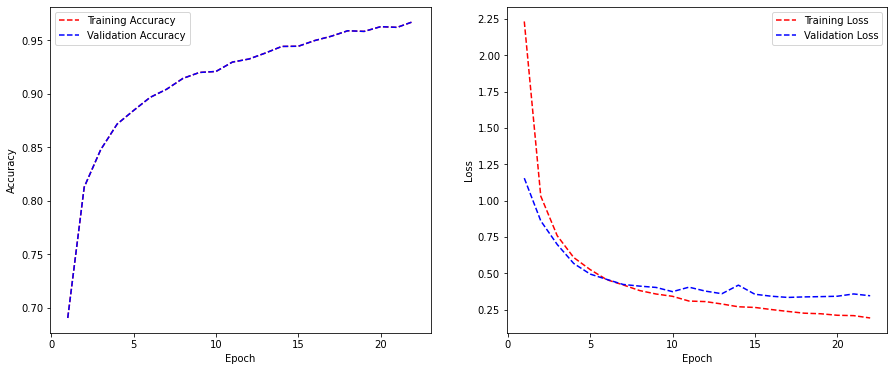

In [ ]:
plot_training_history(hist2)

107/107 [==============================] - 14s 126ms/step - loss: 0.3519 - acc: 0.9120 - precision_m: 1.0991 - recall_m: 1.1553 - f1_m: 1.1257

Metrics
loss: 0.3519
acc: 0.912
precision_m: 1.0991
recall_m: 1.1553
f1_m: 1.1257

107/107 [==============================] - 14s 131ms/step


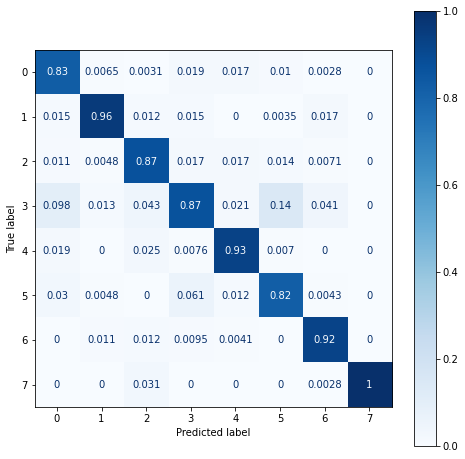

In [ ]:
evaluate_model_performance(model2)

Overall accuracy has improved from 90.82% to 91.20%. The confusion matrix shows that accuracy is more balanced across classes now.<br>
Let's try to improve the accuracy further by tuning the hyperparameters.

In [ ]:
# VGG16 Base
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))
# Freeze all layers except the last two
for i in range(len(conv_base.layers)-2):
    conv_base.layers[i].trainable=False
# Build model
model2_1 = models.Sequential()
model2_1.add(layers.Resizing(IMG_SIZE, IMG_SIZE))
model2_1.add(layers.Rescaling(1./255))
model2_1.add(conv_base)
model2_1.add(layers.Flatten())
model2_1.add(layers.Dense(256, activation='relu', kernel_regularizer='l2'))
model2_1.add(layers.Dropout(0.3)) # Increase Dropout
model2_1.add(layers.Dense(num_classes, activation='softmax'))

In [ ]:
# Compile the model for training
opt = Adam(learning_rate=1e-4)
model2_1.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['acc', precision_m, recall_m, f1_m])

In [ ]:
num_epochs = 25

# Callbacks
model_filepath = '/content/drive/My Drive/BloodMNIST/Models/vgg16_class_weights_1'+'-saved-model-{epoch:02d}-acc-{val_acc:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(model_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=1e-6)

In [ ]:
hist2_1 = model2_1.fit(X_train, y_train,
                 epochs=num_epochs,
                 validation_data=[X_val, y_val],
                 callbacks=[model_checkpoint, early_stopping, reduce_lr],
                 class_weight=class_weights) # Include class weights

Epoch 1/25
374/374 [==============================] - ETA: 0s - loss: 2.2724 - acc: 0.6802 - precision_m: 25000002.0000 - recall_m: 1.6826 - f1_m: 2.0887
Epoch 1: val_acc improved from -inf to 0.82185, saving model to /content/drive/My Drive/BloodMNIST/Models/vgg16_class_weights_1-saved-model-01-acc-0.82.hdf5
374/374 [==============================] - 64s 167ms/step - loss: 2.2724 - acc: 0.6802 - precision_m: 25000002.0000 - recall_m: 1.6826 - f1_m: 2.0887 - val_loss: 1.1428 - val_acc: 0.8218 - val_precision_m: 1.6509 - val_recall_m: 1.4316 - val_f1_m: 1.5297 - lr: 1.0000e-04
Epoch 2/25
374/374 [==============================] - ETA: 0s - loss: 1.0395 - acc: 0.8106 - precision_m: 1.5401 - recall_m: 1.4055 - f1_m: 1.4667
Epoch 2: val_acc improved from 0.82185 to 0.85806, saving model to /content/drive/My Drive/BloodMNIST/Models/vgg16_class_weights_1-saved-model-02-acc-0.86.hdf5
374/374 [==============================] - 61s 163ms/step - loss: 1.0395 - acc: 0.8106 - precision_m: 1.5401 -

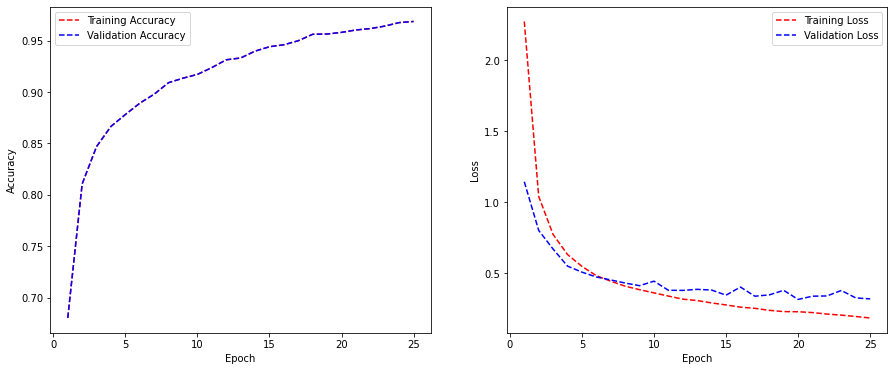

In [ ]:
plot_training_history(hist2_1)

107/107 [==============================] - 13s 124ms/step - loss: 0.3252 - acc: 0.9158 - precision_m: 1.0772 - recall_m: 1.1355 - f1_m: 1.1050

Metrics
loss: 0.3252
acc: 0.9158
precision_m: 1.0772
recall_m: 1.1355
f1_m: 1.105

107/107 [==============================] - 14s 130ms/step


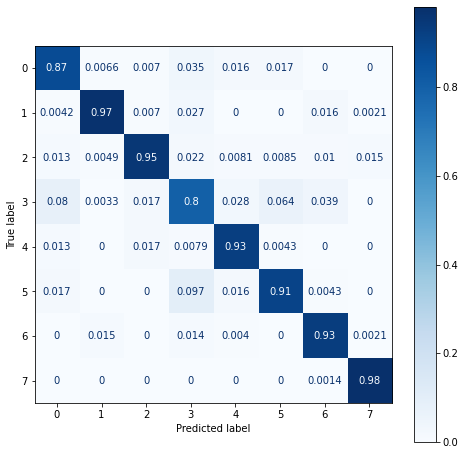

In [ ]:
evaluate_model_performance(model2_1)

# Original Model 1 - using Residual Blocks

In [ ]:
# Chollet, F. (2021) Deep Learning with Python. Shelter Island, New York: Manning Publications Co LLC.
# Available at https://learning.oreilly.com/library/view/deep-learning-with/9781617296864/Text/09.xhtml#heading_id_7 (Accessed: 8th March 2023)
def residual_block(x, filters, pooling=False):
  residual = x
  x = Conv2D(filters, 3, activation='relu', padding='same')(x)
  x = Conv2D(filters, 3, activation='relu', padding='same')(x)
  if pooling:
    x = MaxPool2D(2, padding='same')(x)
    residual = Conv2D(filters, 1, strides=2)(residual)
  elif filters != residual.shape[-1]:
    residual = Conv2D(filters, 1)(residual)
  x = layers.add([x, residual])
  return x

In [ ]:
IMG_SIZE = 224

inputs = keras.Input(shape=(28, 28, 3))
x = layers.Resizing(IMG_SIZE, IMG_SIZE)(inputs)
x = layers.Rescaling(1./255)

x = residual_block(inputs, filters=32, pooling=True)
x = residual_block(x, filters=64, pooling=True)

x = GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu', kernel_regularizer='l2')(x)
x = Dropout(0.2)(x)

outputs = Dense(8, activation='softmax')(x)

model3 = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
# Compile the model for training
opt = Adam(learning_rate=1e-4)
model3.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['acc', precision_m, recall_m, f1_m])

In [ ]:
num_epochs = 25

# Callbacks
model_filepath = '/content/drive/My Drive/BloodMNIST/Models/rbmodel'+'-saved-model-{epoch:02d}-acc-{val_acc:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(model_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=1e-6)

In [ ]:
hist3 = model3.fit(X_train, y_train,
                 epochs=num_epochs,
                 validation_data=[X_val, y_val],
                 callbacks=[model_checkpoint, early_stopping, reduce_lr],
                 class_weight=class_weights) # Include class weights

Epoch 1/25
374/374 [==============================] - ETA: 0s - loss: 12.6979 - acc: 0.2052 - precision_m: 1.3379 - recall_m: 1.3232 - f1_m: 1.3272
Epoch 1: val_acc improved from -inf to 0.45093, saving model to /content/drive/My Drive/BloodMNIST/Models/rbmodel-saved-model-01-acc-0.45.hdf5
374/374 [==============================] - 5s 9ms/step - loss: 12.6979 - acc: 0.2052 - precision_m: 1.3379 - recall_m: 1.3232 - f1_m: 1.3272 - val_loss: 2.6531 - val_acc: 0.4509 - val_precision_m: 2.9304 - val_recall_m: 1.8919 - val_f1_m: 2.2586 - lr: 1.0000e-04
Epoch 2/25
372/374 [============================>.] - ETA: 0s - loss: 2.4308 - acc: 0.4301 - precision_m: 3.3795 - recall_m: 1.9102 - f1_m: 2.4049
Epoch 2: val_acc improved from 0.45093 to 0.54848, saving model to /content/drive/My Drive/BloodMNIST/Models/rbmodel-saved-model-02-acc-0.55.hdf5
374/374 [==============================] - 3s 7ms/step - loss: 2.4295 - acc: 0.4302 - precision_m: 3.3776 - recall_m: 1.9110 - f1_m: 2.4051 - val_loss: 1

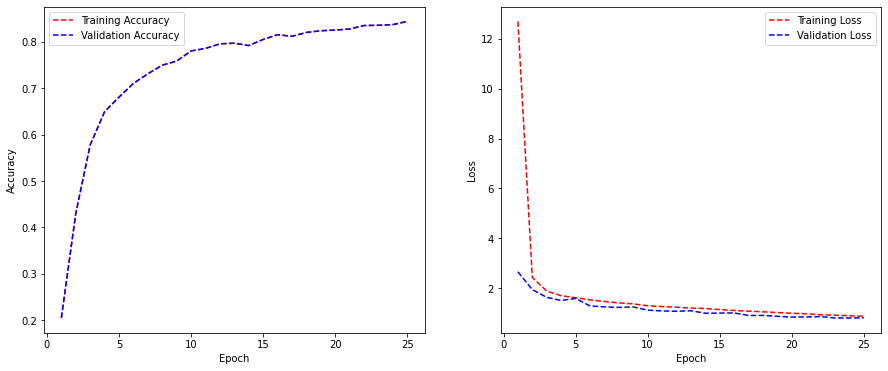

In [ ]:
plot_training_history(hist3)

107/107 [==============================] - 1s 11ms/step - loss: 0.8345 - acc: 0.8261 - precision_m: 1.5642 - recall_m: 1.4401 - f1_m: 1.4971

Metrics
loss: 0.8345
acc: 0.8261
precision_m: 1.5642
recall_m: 1.4401
f1_m: 1.4971

107/107 [==============================] - 1s 4ms/step


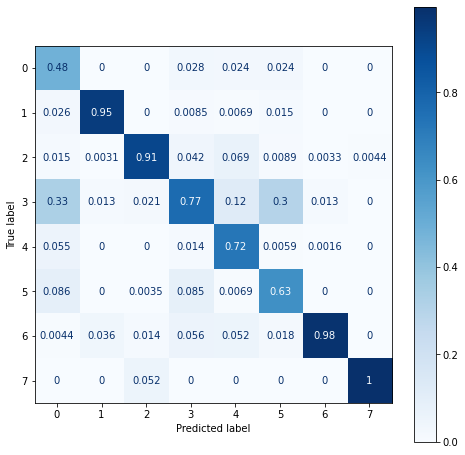

In [ ]:
evaluate_model_performance(model3)

# Original Model 2 - simple CNN using Keras Tuner for hyperparameter tuning

* https://keras.io/api/keras_tuner/tuners/
* https://elitedatascience.com/keras-tutorial-deep-learning-in-python
* https://www.tutorialspoint.com/keras/keras_convolution_neural_network.htm
* **https://pub.towardsai.net/keras-tuner-tutorial-hyperparameter-optimization-tensorflow-keras-computer-vision-example-c9abbdad9887**
*https://www.youtube.com/watch?v=OzLAdpqm35E&list=PL8zVxdmL4bR5p4ZY5TcLo46JmZBMDLGUv&index=3


In [ ]:
def build_model(hp):  
  model = keras.Sequential([
      layers.Input((28,28,3)),
      layers.Resizing(224, 224),
      layers.Rescaling(1./255),
    keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=64, max_value=128, step=16),
        kernel_size=(3,3),
        activation='relu'
        #input_shape=(224,224,3)
    ),
    keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
        kernel_size=(3,3),
        activation='relu'
    ),
    keras.layers.Conv2D(
        filters=hp.Int('conv_3_filter', min_value=16, max_value=32, step=16),
        kernel_size=(3,3),
        activation='relu'
    ),
    keras.layers.Flatten(),
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=256, step=16),
        activation='relu'
    ),
    keras.layers.Dense(8, activation='softmax')
  ])
  
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])),
              loss='sparse_categorical_crossentropy',
              metrics=['acc', precision_m, recall_m, f1_m])
 
  return model

In [ ]:
tuner_search=RandomSearch(build_model,
                          objective='val_loss',
                          max_trials=5, directory='/content/drive/MyDrive/BloodMNIST', project_name="BloodMNIST-Tuner")

In [ ]:
tuner_search.search(X_train,y_train,epochs=3,validation_data=(X_val, y_val),class_weight=class_weights)


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
32                |?                 |conv_1_filter
48                |?                 |conv_2_filter
208               |?                 |dense_1_units
0.001             |?                 |learning_rate

Epoch 1/3
374/374 [==============================] - 4637s 12s/step - loss: 4.3148 - accuracy: 0.5505 - val_loss: 0.8824 - val_accuracy: 0.6560
Epoch 2/3
374/374 [==============================] - 4903s 13s/step - loss: 0.7790 - accuracy: 0.7108 - val_loss: 0.6194 - val_accuracy: 0.7681
Epoch 3/3
 89/374 [======>.......................] - ETA: 1:05:10 - loss: 0.5333 - accuracy: 0.8058

In [ ]:
best_model = tuner_search.get_best_models()[0]

In [ ]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 112)     3136      
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 32)      32288     
                                                                 
 conv2d_2 (Conv2D)           (None, 218, 218, 32)      9248      
                                                                 
 flatten (Flatten)           (None, 1520768)           0         
                                                                 
 dense (Dense)               (None, 192)               2

In [ ]:
# Callbacks
model_filepath = '/content/drive/My Drive/BloodMNIST/Models/keras_tuner_cnn'+'-saved-model-{epoch:02d}-acc-{val_acc:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(model_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Fit model
hist_cnn = best_model.fit(X_train, y_train,
                          epochs=20,
                          validation_data=(X_val, y_val),
                          initial_epoch=3,
                          callbacks=[model_checkpoint, early_stopping],
                          class_weight=class_weights)

Epoch 4/20
374/374 [==============================] - ETA: 0s - loss: 0.3805 - acc: 0.8684
Epoch 4: val_acc improved from -inf to 0.87967, saving model to /content/drive/My Drive/BloodMNIST/keras_tuner_cnn-saved-model-04-acc-0.88.hdf5
374/374 [==============================] - 119s 317ms/step - loss: 0.3805 - acc: 0.8684 - val_loss: 0.3245 - val_acc: 0.8797
Epoch 5/20
374/374 [==============================] - ETA: 0s - loss: 0.3278 - acc: 0.8833
Epoch 5: val_acc did not improve from 0.87967
374/374 [==============================] - 102s 273ms/step - loss: 0.3278 - acc: 0.8833 - val_loss: 0.3741 - val_acc: 0.8721
Epoch 6/20
374/374 [==============================] - ETA: 0s - loss: 0.2916 - acc: 0.8992
Epoch 6: val_acc did not improve from 0.87967
374/374 [==============================] - 102s 273ms/step - loss: 0.2916 - acc: 0.8992 - val_loss: 0.3561 - val_acc: 0.8773
Epoch 7/20
374/374 [==============================] - ETA: 0s - loss: 0.2817 - acc: 0.9012
Epoch 7: val_acc did not 

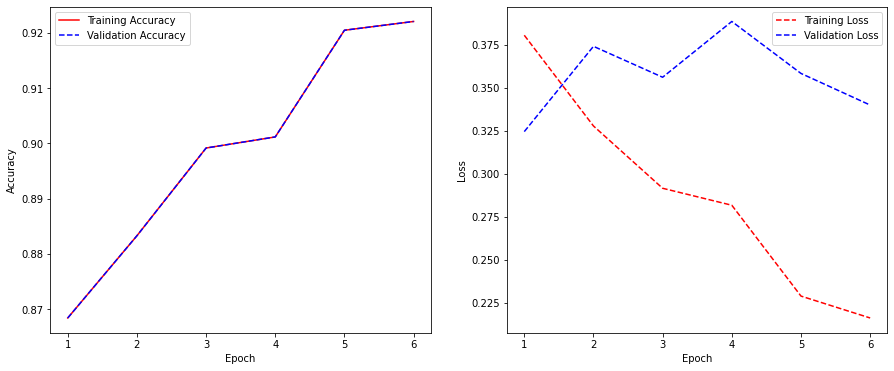

In [ ]:
# Get training and validation accuracy histories
training_accuracy = hist_cnn.history["acc"]
val_accuracy = hist_cnn.history["acc"]
# Get training and validation loss histories
training_loss = hist_cnn.history["loss"]
val_loss = hist_cnn.history["val_loss"]
# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
# Visualise accuracy history
ax[0].plot(epoch_count, training_accuracy, "r")
ax[0].plot(epoch_count, val_accuracy, "b--")
ax[0].legend(["Training Accuracy", "Validation Accuracy"])
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")
# Visualise loss history
ax[1].plot(epoch_count, training_loss, "r--")
ax[1].plot(epoch_count, val_loss, "b--")
ax[1].legend(["Training Loss", "Validation Loss"])
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")

plt.show()

In [ ]:
# Evaluate model
scores_4 = best_model.evaluate(X_test, y_test)

107/107 [==============================] - 6s 53ms/step - loss: 0.3596 - acc: 0.8769


In [ ]:
print('{}: {}%'.format(best_model.metrics_names[1], round(scores_4[1]*100, 2)))

acc: 87.69%


In [ ]:
y_pred_4 = best_model.predict(X_test)
y_pred_4_classes = np.argmax(y_pred_4, axis=1)

107/107 [==============================] - 5s 45ms/step


In [ ]:
print(f1_score(y_test, y_pred_4_classes, average='weighted'))
print(f1_score(y_test, y_pred_4_classes, average='macro'))
print(f1_score(y_test, y_pred_4_classes, average=None))

0.8732181719443105
0.8649178302539526
[0.77757685 0.97770701 0.89731438 0.69338677 0.88741722 0.7915937
 0.89861111 0.99573561]
